In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_iris
import time
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Load the data, which is included in sklearn.
iris = load_iris()
target_names = iris.target_names
feature_names = iris.feature_names
print("""
Iris target names: {target_names}
Iris feature names: {feature_names}
""".format(**locals()))

X, Y = iris.data, iris.target

# Shuffle the data, but make sure that the features and accompanying labels stay in sync.
np.random.seed(0)
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

# Split into train and test.
train_data, train_labels = X[:100], Y[:100]
test_data, test_labels = X[100:], Y[100:]


Iris target names: ['setosa' 'versicolor' 'virginica']
Iris feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']



In [3]:
def EuclideanDistance(v1, v2):
    sum = 0.0
    for index in range(len(v1)):
        sum += (v1[index] - v2[index]) ** 2
    return sum ** 0.5

In [4]:
def cosine_sim(x1, x2):
    mag_x1 = sum(i**2 for i in x1)**0.5
    mag_x2 = sum(i**2 for i in x2)**0.5
    dot = sum(i * j for (i, j) in zip(x1, x2))
    return 1 - dot / float(mag_x1 * mag_x2)

In [11]:
def min_distance(v1, v2):
    return min(abs(v1_i - v2_i) for (v1_i, v2_i) in zip(v1, v2))

Ok now let's create a class that implements a Nearest Neighbors classifier. We'll model it after the sklearn classifier implementations, with fit() and predict() methods.

http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier

In [6]:
class NearestNeighbors:
    # Initialize an instance of the class.
    def __init__(self, metric=EuclideanDistance):
        self.metric = metric
    
    # No training for Nearest Neighbors. Just store the data.
    def fit(self, train_data, train_labels):
        self.train_data = train_data
        self.train_labels = train_labels
        self.candidates = [(datum, label)
                           for (datum, label) in zip(train_data, train_labels)]
    
    # Make predictions for each test example and return results.
    def predict(self, test_data):
        results = []
        for item in test_data:
            results.append(self._predict_item(item))
            
        return results
    
    # Private function for making a single prediction.
    def _predict_item(self, item):
        best_dist, best_label = 1.0e10, None
        for i in range(len(self.train_data)):
            dist = self.metric(self.train_data[i], item)
            if dist < best_dist:
                best_label = self.train_labels[i]
                best_dist = dist
                
        return best_label
        
            
    # Private function for making a single prediction....but based on n nearest neighbors.
    def _predict_item_k(self, item, k=1):
        
        self.candidates.sort(key=lambda datum, label: self.metric(datum, item))
        nearest_labels = [label for (datum, label) in self.candidates[:k]]
        
        # Sort labels by frequency
        votes = {}
        for label in nearest_labels:
            votes[label] = votes.get(label, 0) + 1

        votes = [(label, count) for (label.count) in votes.iteritems()]
        votes.sort(key=lambda label, count: count, reverse=True)
        return votes[0][0]

In [9]:
clf = NearestNeighbors(metric=EuclideanDistance)
clf.fit(train_data, train_labels)
preds = clf.predict(test_data)

correct, total = 0, 0
for pred, label in zip(preds, test_labels):
    if pred == label: correct += 1
    total += 1
print('total: %3d  correct: %3d  accuracy: %3.2f' %(total, correct, 1.0*correct/total))

total:  50  correct:  48  accuracy: 0.96


In [8]:
clf = NearestNeighbors(metric=cosine_sim)
clf.fit(train_data, train_labels)
preds = clf.predict(test_data)

correct, total = 0, 0
for pred, label in zip(preds, test_labels):
    if pred == label: correct += 1
    total += 1
print('total: %3d  correct: %3d  accuracy: %3.2f' %(total, correct, 1.0*correct/total))

total:  50  correct:  47  accuracy: 0.94


In [12]:
clf = NearestNeighbors(metric=min_distance)
clf.fit(train_data, train_labels)
preds = clf.predict(test_data)

correct, total = 0, 0
for pred, label in zip(preds, test_labels):
    if pred == label: correct += 1
    total += 1
print('total: %3d  correct: %3d  accuracy: %3.2f' %(total, correct, 1.0*correct/total))

total:  50  correct:  33  accuracy: 0.66


# Let's dive deeper with generated data

Text(0.5,1,'Data Scatterplot; Red: Class 0; Blue: Class 1')

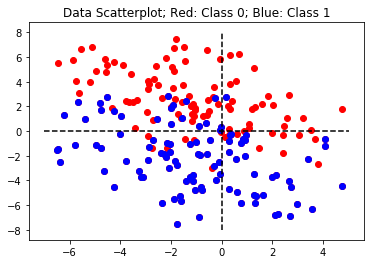

In [14]:
np.random.seed(0) # so things are 'random'


def make_data(n_per_class):
    """Generates data in a 2D space
    
    Args:
        n_per_class(int): number of points to generate per class
    """
    # initializing data arrays
    group = np.empty((0, 2))
    group_labels = np.empty((0, 0))
    
    # a function to define the decision boundary between x and y
    boundary_function = lambda x: (x**3.0 + 3.0 * x**2.0 - 6.0 * x- 8.0) / 4.0
    
    for i in range(2):
        # x values
        x_value = np.random.uniform(-4, 2, size=n_per_class[i])
        
        
        # here's how the decision boundary works: we add noise so the y value point lies above or
        # below the decision boundary
        if i ==0:
            y_noise = np.random.uniform(-0.5, 5.0, size=n_per_class[i])
        else:
            y_noise = np.random.uniform(-5.0, 0.5, size=n_per_class[i])
            
        # make the x and y values
        y_value = boundary_function(x_value) + y_noise
        
        x_noise = np.random.uniform(-3, 3, size=n_per_class[i])
        x_value = x_value + x_noise
        
        # assemble the data
        tmp_group_data = np.append(x_value, y_value)
        tmp_group_data = tmp_group_data.reshape(n_per_class[i], 2, order='F')
    
        # assemble the labels
        tmp_group_labels = np.repeat([i], n_per_class[i])
    
        group = np.vstack((group, tmp_group_data))
        group_labels = np.append(group_labels, tmp_group_labels)
    
    # return a dict of data and labels
    return({'group': group, 'group_labels': group_labels})


# make data; get out the data and labels
training_data = make_data([100, 100])
train_X = training_data['group']
train_labels = training_data['group_labels']

# plot it!
plt.plot(train_X[:, 0], train_X[:, 1], 'ro')
plt.plot(train_X[np.where(train_labels==1), 0][0], 
         train_X[np.where(train_labels==1), 1][0], 'bo')
plt.plot([-7, 5], [0, 0], 'k--')
plt.plot([0, 0], [-8, 8], 'k--')
plt.title("Data Scatterplot; Red: Class 0; Blue: Class 1")

number of incorrect predictions: 33


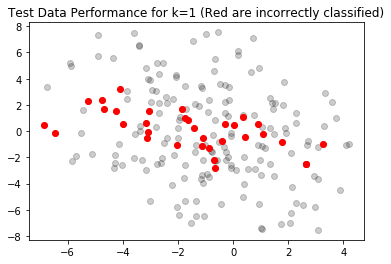

In [15]:
# fit KNN to the data, see what it gets wrong?

np.random.seed(5) # so things are 'random'

test_data = make_data([100, 100])
test_X = test_data['group']
test_true_labels = test_data['group_labels']


def run_KNN_example(k, metric):
    model = KNeighborsClassifier(
        n_neighbors=k,
        metric=metric
    )
    model.fit(train_X, train_labels)
    test_predicted_labels = model.predict(test_X)

    wrong_prediction = (test_predicted_labels != test_true_labels)

    print('number of incorrect predictions:', np.sum(wrong_prediction))

    plt.plot(test_X[:, 0], test_X[:, 1], 'ko', alpha=0.2)
    plt.plot(test_X[np.where(wrong_prediction), 0][0], 
             test_X[np.where(wrong_prediction), 1][0], 'ro')
    plt.title(f'Test Data Performance for k={k} (Red are incorrectly classified)')
    

# TODO try different values of k, how does the model change?
run_KNN_example(1, EuclideanDistance)

number of incorrect predictions: 40


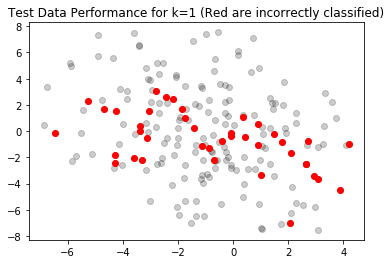

In [16]:
# TODO Why doesn't cosine similarity perform as well? What k does it perform best with?
run_KNN_example(1, cosine_sim)

number of incorrect predictions: 74


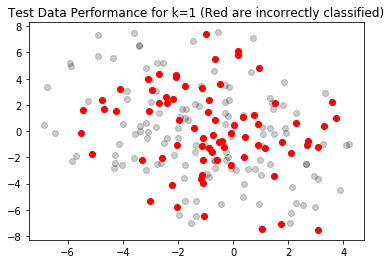

In [17]:
# TODO Why doesn't cosine similarity perform as well? What k does it perform best with?
run_KNN_example(1, min_distance)